In [1]:
import sys
from pathlib import Path
sys.path.append(str(Path.cwd().parent))

import seaborn as sns
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd
import regex

from tqdm import tqdm

In [2]:
from src import utils,physics
from src.density.nfw import NFW
from src.density.hernquist import Hernquist
from src.spatial_approximation import Lattice
from src.halo import Halo
from src.background import Mass_Distribution
from src.constants import G,Msun,kpc,Myr,Gyr,cross_section,km,second

# Constants and general functions

In [3]:
# Mtot = 1.0e10 * Msun #Default halo mass in solar masses (Msun).
# Rs = 2.68441 * kpc #kpc
# c = 17
Mtot_dm = 1.15e9 * Msun
Mtot_b = 1e5 * Msun
Rs = 1.18 * kpc
c = 19
sigma = 50 * cross_section
# sigma = 0

# Setup - DM

In [4]:
n_particles = int(1e5)
density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,unit_mass=Mtot_dm/n_particles)
steps_per_Tdyn = 1000
total_run_time = 61 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=sigma,save_every=save_every,
                  total_run_time=total_run_time,interaction_params={'max_radius_j':10,'rounds':10})

ERROR! Session/line number was not unique in database. History logging moved to new session 1862


In [172]:
x = halo.lattice(halo.r)

In [5]:
# halo.reset()
# halo.evolve(n_Tdyn=1100)
halo.evolve(n_Tdyn=61)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|████████████████████████████████████████████████████████████████| 61000/61000 [15:31<00:00, 65.48it/s]


In [15]:
time = [[step]*len(segment) for step,segment in enumerate(halo.interactions_track)]
data = pd.DataFrame({'step':np.hstack(time),'r':np.hstack(halo.interactions_track)})
data['time'] = data['step']*halo.dt

Text(0.5, 1.0, 'Scattering location distribution within the first 1 Gyr')

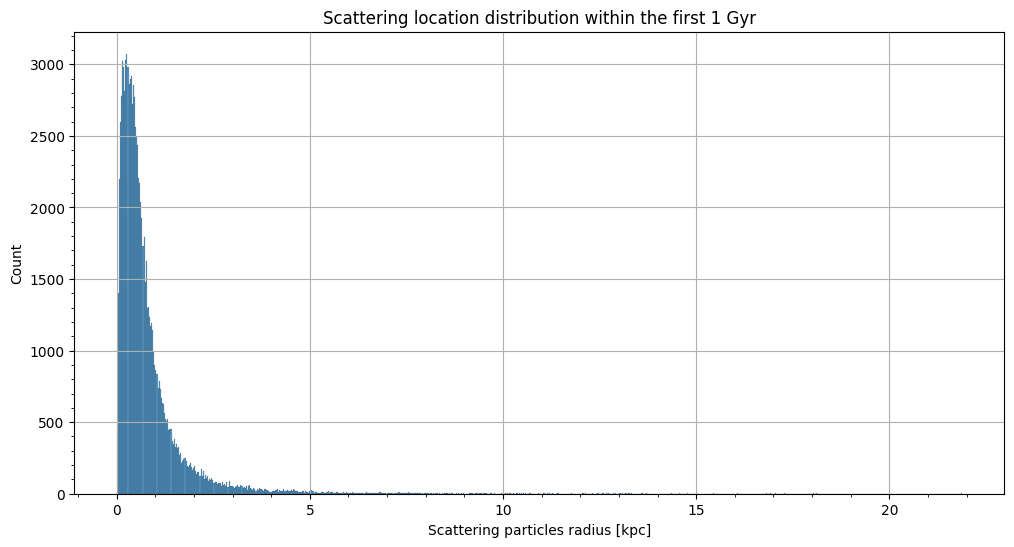

In [35]:
fig,ax = plt.subplots(figsize=(12,6))
# limits = np.arange(0,1000,100)
# for left,right in zip(limits[:-1],limits[1:]):
#     sns.kdeplot(data[data['time'].between(left,right)].r,ax=ax)
sns.histplot(data.r,ax=ax)
ax.minorticks_on()
ax.grid(True)
ax.set_xlabel('Scattering particles radius [kpc]')
ax.set_title('Scattering location distribution within the first 1 Gyr')

In [6]:
halo.saved_states.to_csv('states dm.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

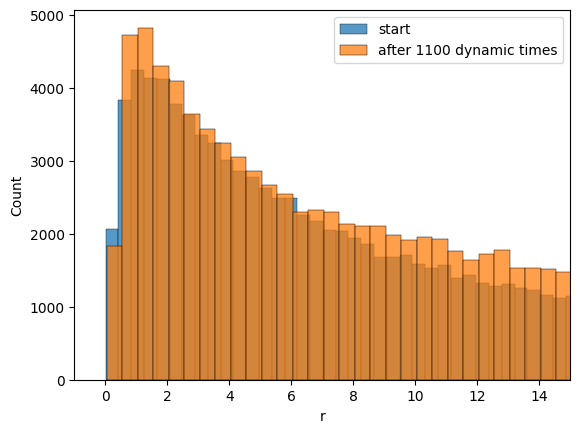

In [7]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

In [9]:
data = halo.saved_states.copy();
data = data[data['r'] < 1*kpc].copy()

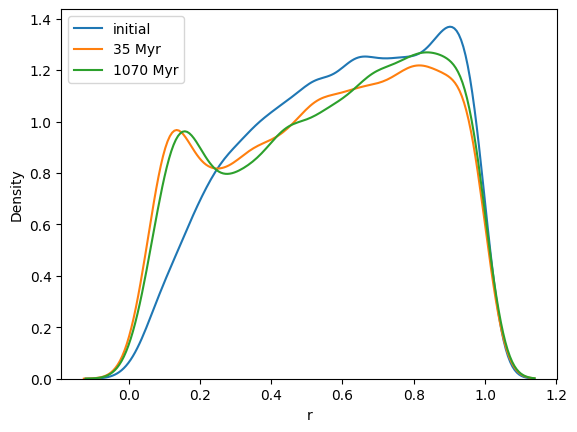

In [10]:
steps = [20000,600000]
time = []
ax = sns.kdeplot(data[data['step'] == 0].r)
for step in steps:
    sns.kdeplot(data[data['step'] == step].r,ax=ax)
    time += [data[data['step'] == step].time.iloc[0]]
ax.legend(['initial']+[f'{int(t)} Myr' for t in time])

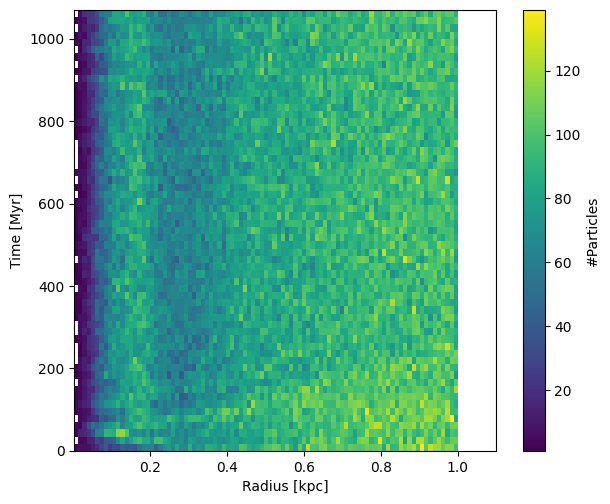

In [13]:
data = halo.saved_states.copy();
data = data[data['r'] < 1*kpc].copy()

data['output'] = data.r
length_units = {'value':kpc,'name':'kpc'}
time_units = {'name':'Myr','value':Myr}
# time_units = {'name':'scattering time','value':110*Myr}
grid,extent = halo.prep_2d_data(data,radius_cutoff=5,x_units=length_units,time_units=time_units,agg_fn='count')

utils.plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='#Particles',
              x_tick_format='%.1f');

In [44]:
110/halo.dt/12

np.float64(5140.080147674324)

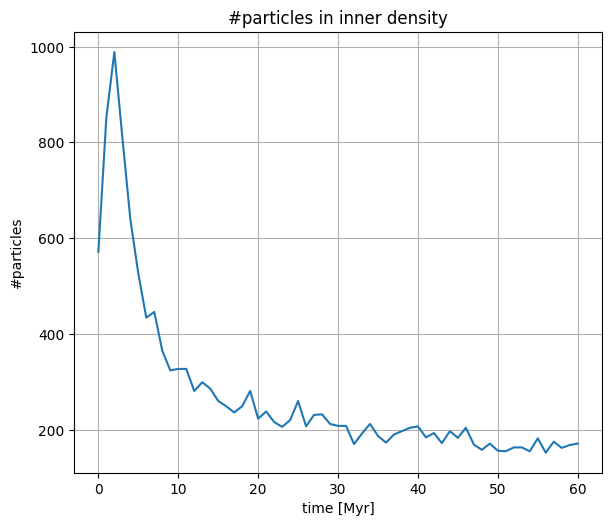

In [8]:
halo.plot_inner_core_density();

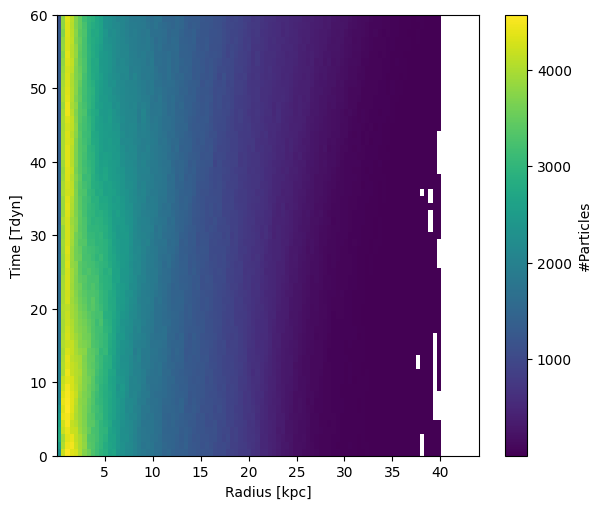

In [9]:
halo.plot_density_evolution();

/home/rotembarnea/Documents/SIDM/pySIDM/src/halo.py:293: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,'bin'] = lattice.posts[lattice(data.r.to_numpy())]


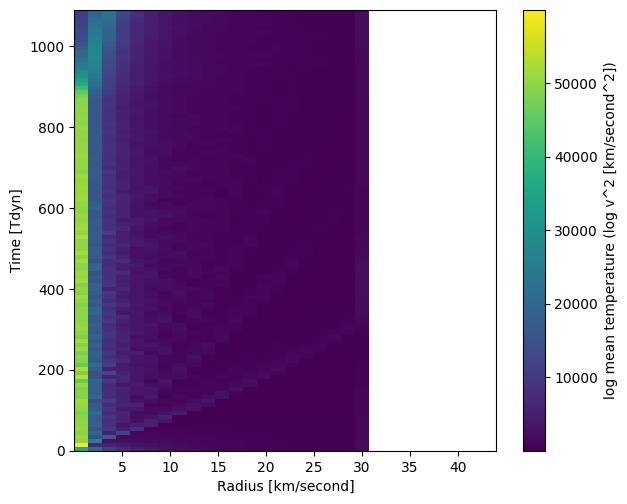

In [8]:
halo.plot_temperature();

# Setup - B matter

In [7]:
n_particles = int(1e5)
dm_density = NFW(Rs=Rs,c=c,Mtot=Mtot_dm,unit_mass=Mtot_dm/n_particles)
density = Hernquist(Rs=Rs,Mtot=Mtot_b,unit_mass=Mtot_b/n_particles)
density.Tdyn = dm_density.Tdyn
steps_per_Tdyn = 1000
total_run_time = 1100 * density.Tdyn
save_every = 10*density.Tdyn

halo = Halo.setup(density=density,steps_per_Tdyn=steps_per_Tdyn,n_particles=n_particles,sigma=0,save_every=save_every,
                  total_run_time=total_run_time,mass_calculation_method='lattice')
halo.add_background(Mass_Distribution.from_files(halo.lattice,Mtot=Mtot_dm,base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12525000,tfinal=1100,
                                                 max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data'))

Load files: 100%|███████████████████████████████████████████████████████| 501/501 [00:01<00:00, 309.97it/s]


In [8]:
# halo.reset()
halo.evolve(n_Tdyn=1100)
# halo.evolve(n_Tdyn=81)
# halo.evolve(n_Tdyn=6)
# halo.evolve(n_Tdyn=1)

100%|███████████████████████████████████████████████████████████| 1100000/1100000 [44:02<00:00, 416.32it/s]


In [13]:
halo.saved_states.to_csv('states dm.csv')

In [ ]:
fig,ax = halo.plot_r_density_over_time(clip=(0,70))

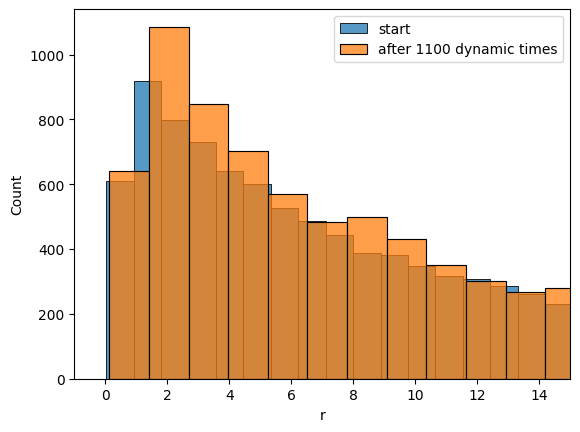

In [14]:
ax = sns.histplot(halo.initial_particles.r/kpc)
sns.histplot((halo.particles.r/kpc)[(halo.particles.r/kpc) < 50],ax=ax)
ax.set_xlim((-1,15))
ax.legend(['start','after 1100 dynamic times'])

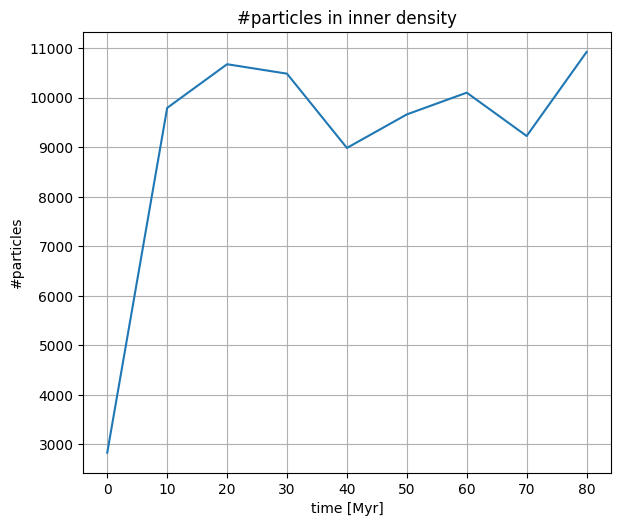

In [21]:
halo.plot_inner_core_density();

In [10]:
halo.saved_states.to_csv('states high amount.csv')

In [34]:
(data.time.unique() <= 12).argmin()

np.int64(68)

In [43]:
from src import nsphere
nsphere.gather_files(base_filename='Rank_Mass_Rad_VRad_unsorted',ntimesteps=12550000,tfinal=1100,
                     max_time=19.605*Gyr,root_path='../../NSphere-SIDM/data/results')

,path,save_step,time,record_dtype
106,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,0,0.000000,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
211,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,2,78.107570,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
173,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,4,156.215139,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
114,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,6,234.322709,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
240,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,8,312.430279,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
...,...,...,...,...
39,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,493,19253.515936,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
107,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,495,19331.623506,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
54,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,497,19409.731076,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."
205,../../NSphere-SIDM/data/results/Rank_Mass_Rad_...,499,19487.838645,"[('rank', '<i4'), ('mass', '<f4'), ('R', '<f4'..."


In [48]:
np.sqrt(Rs**3/(G*Mtot_dm))

np.float64(17.833703762020537)

In [46]:
40/halo.Tdyn

np.float64(2.2429440644397047)

In [61]:
from matplotlib.colors import PowerNorm
norm=PowerNorm(gamma=3/4,vmin=vmin,vmax=vmax)

In [87]:
from src.constants import Unit,default_units
import matplotlib.ticker as mtick
def plot_2d(grid,extent=None,x_range=None,y_range=None,x_units:Unit=default_units(''),y_units:Unit=default_units(''),cbar_units:Unit=default_units(''),
    x_nbins:int|None=6,y_nbins:int|None=6,x_tick_format:str='%.0f',y_tick_format:str='%.0f',title='',xlabel='',ylabel='',cbar_label='',fig=None,ax=None):
    if extent is None:
        if x_range is None:
            x_range = np.array([1e-2,50])*kpc/x_units['value']
        if y_range is None:
            y_range = np.array([0,100])*(km/second)/y_units['value']
        extent = (x_range.min(),x_range.max(),y_range.min(),y_range.max())

    if fig is None or ax is None:
        fig,ax = plt.subplots(figsize=(6,5))
    fig.tight_layout()
    im = ax.imshow(grid,origin='lower',aspect='auto',extent=extent,vmin=0,vmax=3000)
    cbar = fig.colorbar(im,ax=ax)
    if cbar_label:
        cbar.set_label(cbar_label.format(**cbar_units))

    if x_nbins is not None:
        ax.xaxis.set_major_locator(mtick.MaxNLocator(nbins=x_nbins))
        ax.xaxis.set_major_formatter(mtick.FormatStrFormatter(x_tick_format))
        ax.xaxis.tick_bottom()
        for lab in ax.get_xticklabels():
            lab.set_rotation(0)
            lab.set_horizontalalignment('center')
    ax.set_xlabel(xlabel.format(**x_units))

    if y_nbins is not None:
        ax.yaxis.set_major_locator(mtick.MaxNLocator(nbins=y_nbins))
        ax.yaxis.set_major_formatter(mtick.FormatStrFormatter(y_tick_format))
    ax.set_ylabel(ylabel.format(**y_units))
    if title:
        ax.set_title(title)
    return fig,ax

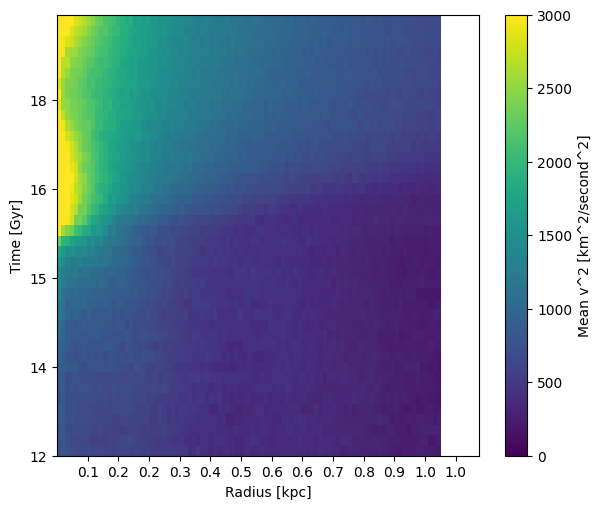

In [97]:
data = halo.saved_states.copy()
data['output'] = (data.v_norm/(km/second))**2
time_units={'name':'Gyr','value':Gyr}
length_units={'name':'kpc','value':kpc}
grid,extent = halo.prep_2d_data(data,radius_cutoff=1*kpc,x_units=length_units,time_units=time_units,agg_fn='mean')

grid = grid[68:]
extent = (extent[0],extent[1],12,extent[3])

plot_2d(grid,extent=extent,x_units=length_units,y_units=time_units,xlabel='Radius [{name}]',ylabel='Time [{name}]',cbar_label='Mean v^2 [km^2/second^2]',
        x_nbins=15,x_tick_format='%.1f');

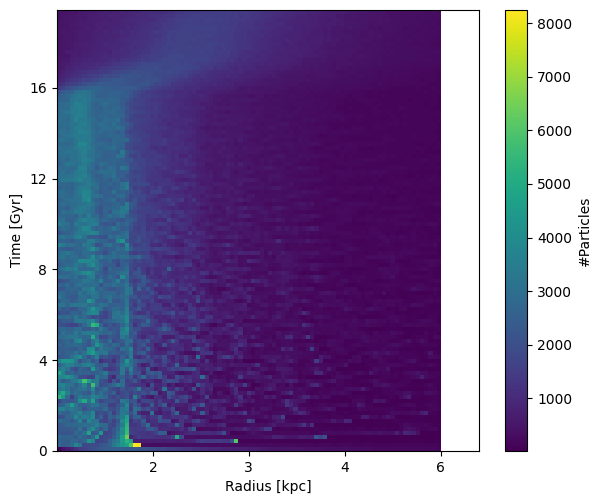

In [13]:
halo.plot_density_evolution(radius_cutoff=6*kpc,time_units={'name':'Gyr','value':Gyr});

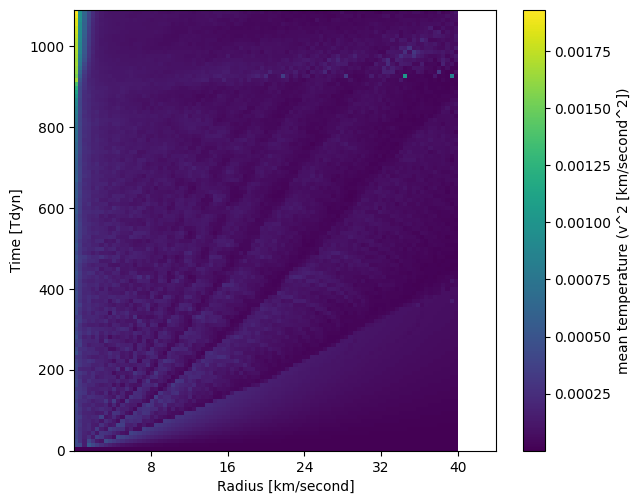

In [51]:
halo.plot_temperature();

# Results:

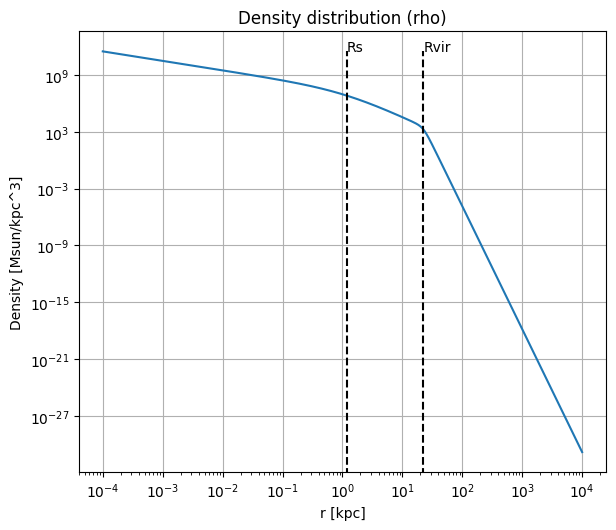

In [5]:
halo.density.plot_rho();

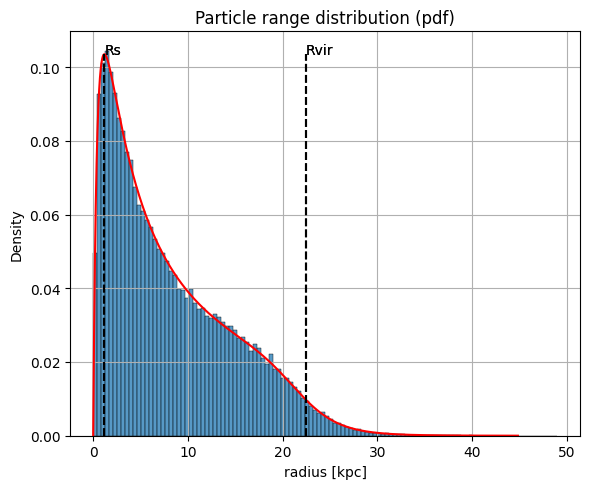

In [5]:
halo.plot_r_distribution(halo.initial_particles,cumulative=False);

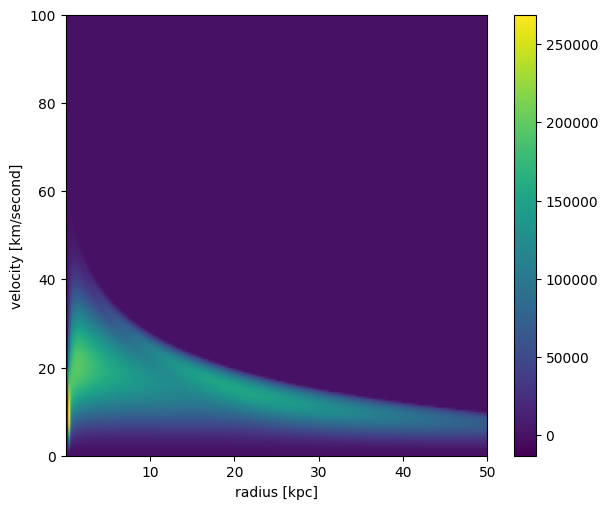

In [9]:
halo.density.plot_phase_space();

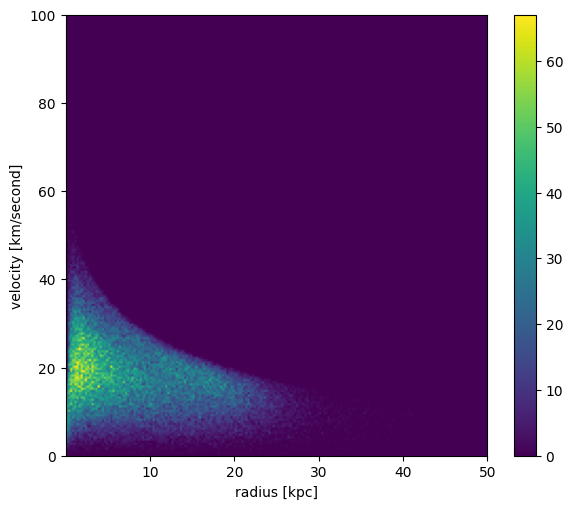

In [10]:
halo.plot_phase_space(halo.initial_particles);